In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import random
import cv2


In [2]:

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ハイパーパラメータの設定
num_epochs = 100
batch_size = 128
learning_rate = 0.001
momentum = 0.9

# CIFAR-10データセットの準備
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Using device: cuda


In [3]:

# Self-Attention層の定義
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Attention weight
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, height, width = x.size()
        proj_query = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)  # B x (H*W) x C'
        proj_key = self.key(x).view(batch_size, -1, height * width)  # B x C' x (H*W)
        energy = torch.bmm(proj_query, proj_key)  # batch matrix multiplication: B x (H*W) x (H*W)
        attention = self.softmax(energy)  # B x (H*W) x (H*W)
        proj_value = self.value(x).view(batch_size, -1, height * width)  # B x C x (H*W)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1)).view(batch_size, C, height, width)  # B x C x H x W

        return self.gamma * out + x, attention

# CNNモデルの定義 (pool1とpool3を除去)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        # self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 削除
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 削除
        self.attention = SelfAttention(128)  # Self-Attention層を追加
        # 全結合層の入力サイズの計算 (32x32 -> conv1 -> 32x32 -> conv2 -> 16x16 -> conv3 -> 16x16)
        # プーリング層を2つしか通らないため、最終的な特徴マップのサイズは 16x16
        self.fc1 = nn.Linear(128 * 16 * 16, 512) # 入力サイズを調整
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        # x = self.pool1(x) # 削除
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        # x = self.pool3(x) # 削除
        x, attention_map = self.attention(x)  # Self-Attention層を通過
        x = x.view(-1, 128 * 16 * 16) # viewのサイズを調整
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x, attention_map  # アテンションマップを返すように変更

    def get_features(self, x):
        x = self.relu1(self.conv1(x))
        # x = self.pool1(x) # 削除
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        # x = self.pool3(x) # 削除
        x, _ = self.attention(x)
        x = x.view(-1, 128 * 16 * 16) # viewのサイズを調整
        return x


In [4]:

# モデルのインスタンス化
net = Net().to(device)

# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# 学習の記録用リスト
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 学習ループ
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs, _ = net(inputs)  # アテンションマップはここでは使用しない
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # テストフェーズ
    net.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs, _ = net(images)  # アテンションマップはここでは使用しない
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')


Epoch [1/100], Train Loss: 2.2391, Train Accuracy: 18.66%
Epoch [1/100], Test Loss: 2.0672, Test Accuracy: 26.61%
Epoch [2/100], Train Loss: 1.9989, Train Accuracy: 28.20%
Epoch [2/100], Test Loss: 1.8672, Test Accuracy: 32.99%
Epoch [3/100], Train Loss: 1.8331, Train Accuracy: 33.87%
Epoch [3/100], Test Loss: 1.6544, Test Accuracy: 41.22%
Epoch [4/100], Train Loss: 1.6831, Train Accuracy: 39.03%
Epoch [4/100], Test Loss: 1.5466, Test Accuracy: 44.53%
Epoch [5/100], Train Loss: 1.5997, Train Accuracy: 41.93%
Epoch [5/100], Test Loss: 1.4825, Test Accuracy: 46.20%
Epoch [6/100], Train Loss: 1.5406, Train Accuracy: 44.01%
Epoch [6/100], Test Loss: 1.4322, Test Accuracy: 48.09%
Epoch [7/100], Train Loss: 1.4848, Train Accuracy: 46.49%
Epoch [7/100], Test Loss: 1.3685, Test Accuracy: 50.71%
Epoch [8/100], Train Loss: 1.4371, Train Accuracy: 48.49%
Epoch [8/100], Test Loss: 1.3196, Test Accuracy: 52.78%
Epoch [9/100], Train Loss: 1.3980, Train Accuracy: 49.49%
Epoch [9/100], Test Loss: 1.33

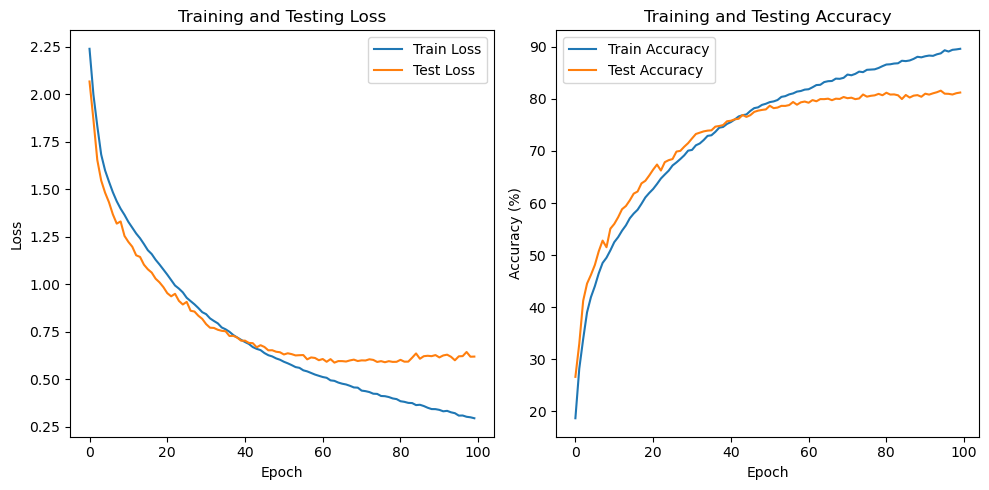

In [5]:

# 学習曲線のプロット (変更なし)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



(10000, 32768) (10000,)


/tmp/ipykernel_28352/2534085258.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes)) # または plt.cm.get_cmap('Set1', len(classes)) など


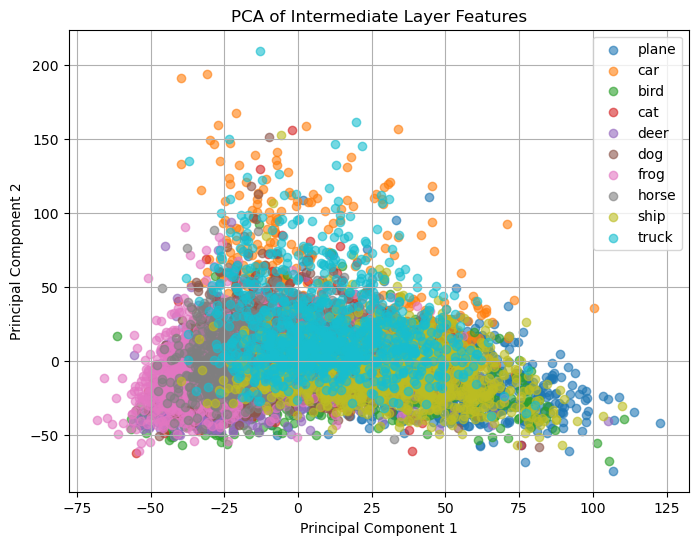

In [6]:
# 中間層の特徴ベクトルの可視化
net.eval()
all_features = []
all_labels = []
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
#        if i >= 10:  # 最初の10バッチのみ使用 (計算量を抑えるため)
#            break
        images = images.to(device)
        features = net.get_features(images).cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print(all_features.shape, all_labels.shape)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(all_features)

# 色使いの変更: 'viridis' を 'tab10' または 'Set1' などに変更
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', len(classes)) # または plt.cm.get_cmap('Set1', len(classes)) など

for i in range(len(classes)):
    indices = np.where(all_labels == i)[0]
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1],
                label=classes[i], alpha=0.6, c=[colors(i)])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Intermediate Layer Features')
plt.legend()
plt.grid(True)
plt.show()



Visualizing attention for sample with label: deer


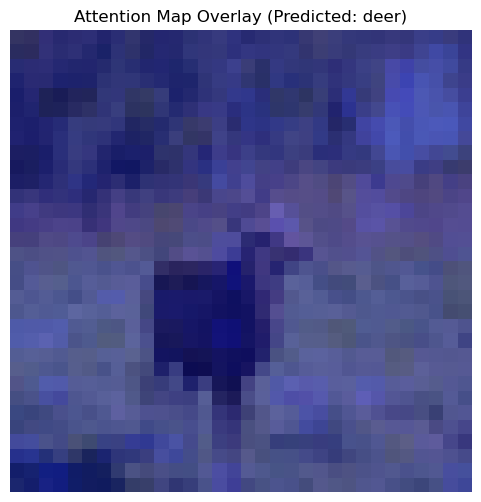

Visualizing attention for sample with label: bird


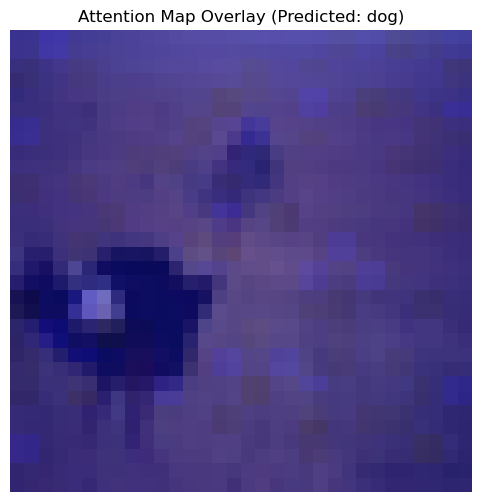

Visualizing attention for sample with label: plane


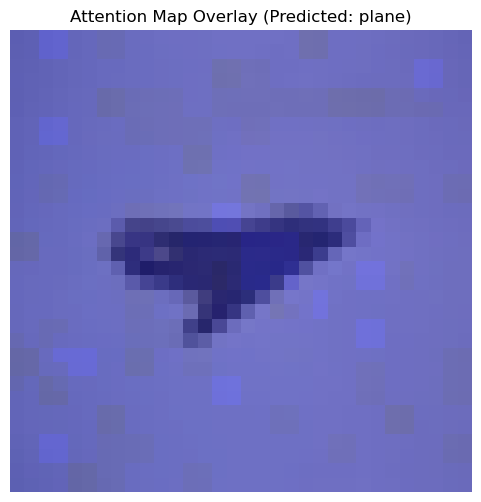

Visualizing attention for sample with label: frog


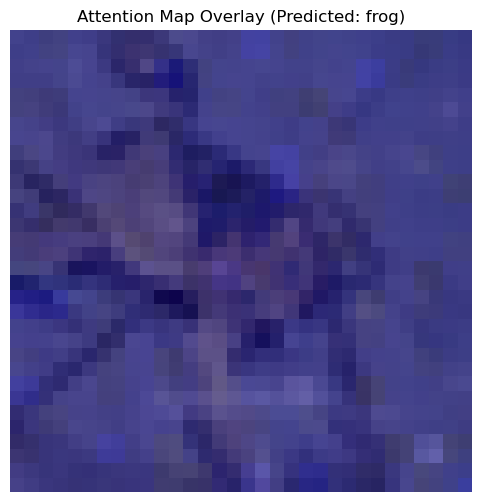

Visualizing attention for sample with label: plane


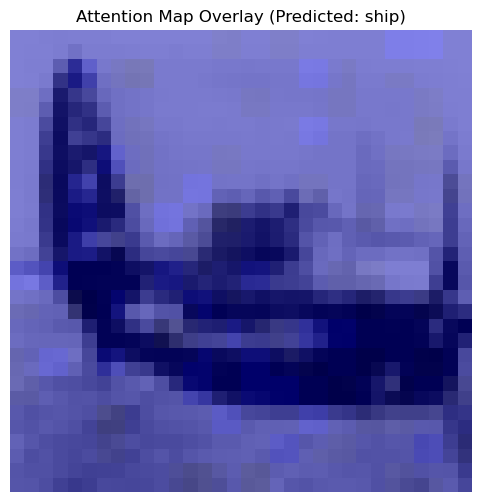

In [7]:
# 学習後のアテンションの可視化 (変更)
def visualize_attention_on_image(model, image, original_image, class_names):
    model.eval()
    with torch.no_grad():
        # 入力画像をデバイスに移動し、バッチ次元を追加
        image_tensor = image.unsqueeze(0).to(device)
        output, attention_map = model(image_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_class = class_names[predicted_idx.item()]

        # アテンションマップをCPUとNumPy配列に移動
        attention_map = attention_map.squeeze(0).cpu().numpy()
        # アテンションマップのサイズは (H*W) x (H*W)
        # H, W はプーリング後の特徴マップのサイズ (16x16) になるはず
        # attention_map を 16x16 のグリッドとして可視化するためにreshape
        attn_map = attention_map.reshape(16, 16, 16, 16).mean(axis=(2, 3)) # 各16x16のブロックの平均を取る

        # ヒートマップのサイズを入力画像のサイズに合わせる
        original_height, original_width = original_image.shape[1], original_image.shape[2]
        attn_map_resized = cv2.resize(attn_map, (original_width, original_height))

        # 0から1の範囲に正規化
        attn_map_normalized = (attn_map_resized - np.min(attn_map_resized)) / (np.max(attn_map_resized) - np.min(attn_map_resized) + 1e-8) # ゼロ除算回避
        heatmap = cv2.applyColorMap(np.uint8(255 * attn_map_normalized), cv2.COLORMAP_JET)
        heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # オリジナル画像をRGBに変換
        original_image_rgb = (original_image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255
        original_image_rgb = original_image_rgb.astype(np.uint8)

        # サイズが一致しているか確認 (デバッグ用)
        if original_image_rgb.shape[:2] != heatmap_rgb.shape[:2] or original_image_rgb.shape[2] != 3 or heatmap_rgb.shape[2] != 3:
            print(f"Error: Shape mismatch before overlaying.")
            print(f"Original Image Shape: {original_image_rgb.shape}")
            print(f"Heatmap Shape: {heatmap_rgb.shape}")
            return

        # ヒートマップをオーバーレイ
        alpha = 0.5  # 透明度
        overlay = cv2.addWeighted(original_image_rgb, 1 - alpha, heatmap_rgb, alpha, 0)

        plt.figure(figsize=(6, 6))
        plt.imshow(overlay)
        plt.title(f'Attention Map Overlay (Predicted: {predicted_class})')
        plt.axis('off')
        plt.show()

# テストデータからランダムなサンプルを選択
num_samples_to_visualize = 5
indices = random.sample(range(len(testset)), num_samples_to_visualize)
for index in indices:
    img, label = testset[index]
    original_img = img.clone() # 可視化用にオリジナルのテンソルを保持
    class_name = classes[label]
    print(f"Visualizing attention for sample with label: {class_name}")
    visualize_attention_on_image(net, img, original_img, classes)